In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns

from cobra import Reaction, Metabolite
from cobra.io import read_sbml_model
from math import log
from pathlib import Path

In [2]:
path = Path(r"C:\Users\mkcoo\Documents\UW\GitHub\PNSB\PettRidge\rpal.xml")
model = read_sbml_model(str(path.resolve()))

mdetails = pd.read_excel(r'C:\Users\mkcoo\Documents\UW\GitHub\PNSB\PettRidge\modelDetails.xlsx', sheet_name='Reactions')

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C00234 "10-Formyltetrahydrofolate">
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C15606 "1,2-dihydroxy-3-keto-5-methylthiopentene">
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C00641DA "1,2-Diacyl-sn-glycerol (Dark Aerobic)">
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C00641LN "1,2-Diacyl-sn-glycerol (Light Anaerobic)">
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C04092 "1,2-Didehydropiperidine-2-carboxylate">
Use of the species charge attribute is discouraged, use fbc:charge instead: <Species C05758 "trans-Dodec-2-enoyl-[acp]">
Use of the spec

## Setting relevant bounds and uptake rate(s)

In [3]:
# Setting acetate uptake rate to 0
model.reactions.XR57.bounds = (0, 0) # acetate

# CO2 import/export bounds
model.reactions.XR72.bounds = (0, 0)
model.reactions.XR73.bounds = (0, 1000)

# Permitting metabolite efflux for acetate
model.reactions.XR59.bounds = (0, 100)

## Standard conditions

In [6]:
# Define uptake ranges
succ_rates = np.linspace(0.1, 2, 50)

# Initialize results
succ_dtimes = []
succ_cfixes = []

# Collect simulation results
for i, succ_rate in enumerate(succ_rates):
    model.reactions.XR80.bounds = (succ_rate, succ_rate) # Succinate
    
    solution = model.optimize()
    mu = solution.objective_value

    if mu > 0:
        # succ_dtimes.append(log(2) / mu) # doubling time (hr)
        succ_dtimes.append(mu*24)
        # succ_dtimes.append(mu) # objective value (1/hr)
        succ_stand_df = solution.to_frame()
        succ_cfixes.append(succ_stand_df.loc['R00024'].fluxes)

In [7]:
model.reactions.XR80.bounds = (0, 0)   # Reset succinate uptake rate to 0

In [8]:
# Define uptake ranges
ac_rates = np.linspace(0.1, 3, 50)

# Initialize results
ac_dtimes = []
ac_cfixes = []

# Collect simulation results
for i, ac_rate in enumerate(ac_rates):
    model.reactions.XR57.bounds = (ac_rate, ac_rate) # Succinate
    
    solution = model.optimize()
    mu = solution.objective_value

    if mu > 0:
        # ac_dtimes.append(log(2) / mu) # doubling time (hr)
        ac_dtimes.append(mu*24)
        # ac_dtimes.append(mu) # objective value (1/hr)
        ac_stand_df = solution.to_frame()
        ac_cfixes.append(ac_stand_df.loc['R00024'].fluxes)

In [9]:
model.reactions.XR57.bounds = (0, 0)   # Reset acetate uptake rate to 0

In [10]:
# Define uptake ranges
cou_rates = np.linspace(0.1, 1, 50)

# Initialize results
cou_dtimes = []
cou_cfixes = []

# Collect simulation results
for i, cou_rate in enumerate(cou_rates):
    model.reactions.XR242.bounds = (cou_rate, cou_rate) # Succinate
    
    solution = model.optimize()
    mu = solution.objective_value

    if mu > 0:
        # cou_dtimes.append(log(2) / mu) # doubling time (hr)
        cou_dtimes.append(mu*24)
        # cou_dtimes.append(mu) # objective value (1/hr)
        cou_stand_df = solution.to_frame()
        cou_cfixes.append(cou_stand_df.loc['R00024'].fluxes)

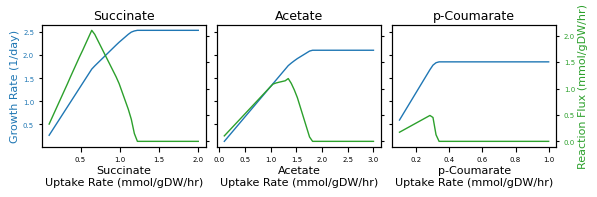

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Smaller font and layout settings
plt.rcParams.update({
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'xtick.labelsize': 5,
    'ytick.labelsize': 5
})

fig, axes = plt.subplots(1, 3, figsize=(6, 2))

data = [
    ("Succinate", succ_rates, succ_dtimes, succ_cfixes),
    ("Acetate", ac_rates, ac_dtimes, ac_cfixes),
    ("p-Coumarate", cou_rates, cou_dtimes, cou_cfixes),
]

# ---- Compute global axis limits ----
all_growth = np.concatenate([d[2] for d in data])   # all dtimes
all_cfix = np.concatenate([d[3] for d in data])     # all cfixes

growth_min, growth_max = np.nanmin(all_growth), np.nanmax(all_growth)
cfix_min, cfix_max = np.nanmin(all_cfix), np.nanmax(all_cfix)

# Add a small margin so lines don't hit the border
growth_margin = 0.05 * (growth_max - growth_min)
cfix_margin = 0.05 * (cfix_max - cfix_min)

# ---- Plot ----
for i, (ax1, (substrate, rates, dtimes, cfixes)) in enumerate(zip(axes, data)):
    color1 = 'tab:blue'
    ax1.set_xlabel(f'{substrate}\nUptake Rate (mmol/gDW/hr)', labelpad=2)
    ax1.plot(rates, dtimes, label='Growth', color=color1, linewidth=1)
    ax1.tick_params(axis='y', labelcolor=color1, length=2)
    ax1.set_ylim(growth_min - growth_margin, growth_max + growth_margin)

    # Second y-axis for carbon fixation
    ax2 = ax1.twinx()
    color2 = 'tab:green'
    ax2.plot(rates, cfixes, label='Carbon Fixation', color=color2, linewidth=1)
    ax2.tick_params(axis='y', labelcolor=color2, length=2)
    ax2.set_ylim(cfix_min - cfix_margin, cfix_max + cfix_margin)

    # Add y-axis labels only on outer plots
    if i == 0:
        ax1.set_ylabel('Growth Rate (1/day)', color=color1, labelpad=2)
    else:
        ax1.set_yticklabels([])

    if i == len(axes) - 1:
        ax2.set_ylabel('Reaction Flux (mmol/gDW/hr)', color=color2, fontsize=8, labelpad=2)
    else:
        ax2.set_yticklabels([])

    ax1.set_title(substrate, pad=4)

plt.tight_layout(pad=1.0, w_pad=0.5)
plt.savefig("Fig1A.svg", bbox_inches='tight')
plt.show()

## Make NAD(P)H heatmaps

In [11]:
model.reactions.XR242.bounds = (0, 0)   # Reset coumarate uptake rate to 0

In [12]:
def get_cofactor_reaction_fluxes(model, solution, met_id):
    """Return a DataFrame of reactions involving a given metabolite with their flux contribution."""
    met = model.metabolites.get_by_id(met_id)
    data = []
    for rxn in met.reactions:
        coeff = rxn.metabolites[met]
        flux = solution.fluxes[rxn.id]
        relflux = flux/solution.objective_value
        contribution = coeff * relflux  # positive: produced, negative: consumed
        if abs(contribution) > 1e-6:  # filter tiny fluxes
            data.append((rxn.id, rxn.name, contribution))
    df = pd.DataFrame(data, columns=["Reaction", "Name", "Cofactor_flux"])
    return df.sort_values("Cofactor_flux", key=abs, ascending=False)

In [13]:
model.reactions.XR57.bounds = (0.5, 0.5) # acetate
solution = model.optimize()
a1_nadh_df = get_cofactor_reaction_fluxes(model, solution, "C00004")
a1_nadph_df = get_cofactor_reaction_fluxes(model, solution, "C00005")

model.reactions.XR57.bounds = (1.25, 1.25) # acetate
solution = model.optimize()
a2_nadh_df = get_cofactor_reaction_fluxes(model, solution, "C00004")
a2_nadph_df = get_cofactor_reaction_fluxes(model, solution, "C00005")

model.reactions.XR57.bounds = (1.6, 1.6) # acetate
solution = model.optimize()
a3_nadh_df = get_cofactor_reaction_fluxes(model, solution, "C00004")
a3_nadph_df = get_cofactor_reaction_fluxes(model, solution, "C00005")

model.reactions.XR57.bounds = (2.5, 2.5) # acetate
solution = model.optimize()
a4_nadh_df = get_cofactor_reaction_fluxes(model, solution, "C00004")
a4_nadph_df = get_cofactor_reaction_fluxes(model, solution, "C00005")

In [14]:
model.reactions.XR57.bounds = (0, 0)

In [15]:
model.reactions.XR242.bounds = (0.2, 0.2) # coumarate
solution = model.optimize()
c1_nadh_df = get_cofactor_reaction_fluxes(model, solution, "C00004")
c1_nadph_df = get_cofactor_reaction_fluxes(model, solution, "C00005")

model.reactions.XR242.bounds = (0.3, 0.3) # coumarate
solution = model.optimize()
c2_nadh_df = get_cofactor_reaction_fluxes(model, solution, "C00004")
c2_nadph_df = get_cofactor_reaction_fluxes(model, solution, "C00005")

model.reactions.XR242.bounds = (0.35, 0.35) # coumarate
solution = model.optimize()
c3_nadh_df = get_cofactor_reaction_fluxes(model, solution, "C00004")
c3_nadph_df = get_cofactor_reaction_fluxes(model, solution, "C00005")

model.reactions.XR242.bounds = (0.5, 0.5) # coumarate
solution = model.optimize()
c4_nadh_df = get_cofactor_reaction_fluxes(model, solution, "C00004")
c4_nadph_df = get_cofactor_reaction_fluxes(model, solution, "C00005")

In [16]:
# Concatenate and label them
def label_df(df, label):
    df = df.copy()
    df['Condition'] = label
    return df

# Pivot to wide format: index=reaction, columns=condition
def prep_for_barplot(df):
    return df.pivot_table(index='Reaction', columns='Condition', values='Cofactor_flux').fillna(0)

# Plotting
def plot_grouped_bars(df, title):
    ax = df.plot(kind='bar', figsize=(12, 6), width=0.75)
    ax.set_ylabel("Cofactor Flux")
    ax.set_xlabel("Reaction")
    ax.set_title(title)
    ax.axhline(0, color='black', linewidth=0.8)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def writeDicts(rxns):
    rid2name = {}
    rxnclasses = {}

    for rxn in rxns:
        match = mdetails[mdetails['Rxn name'] == rxn]
        if not match.empty:
            rid2name[rxn] = match['Detail'].values[0]
            rxnclasses[rxn] = match['Pathway'].values[0]
        else:
            print(f"Warning: {rxn} not found in mdetails.")
            rid2name[rxn] = 'Unknown'
            rxnclasses[rxn] = 'Unknown'

    return rid2name, rxnclasses

In [ ]:
dfs_anadh = [
    label_df(a1_nadh_df, '0.5'),
    label_df(a2_nadh_df, '1.25'), 
    label_df(a3_nadh_df, '1.6'),
    label_df(a4_nadh_df, '2.5')
]

dfs_anadph = [
    label_df(a1_nadph_df, '0.5'),
    label_df(a2_nadph_df, '1.25'), 
    label_df(a3_nadph_df, '1.6'),
    label_df(a4_nadph_df, '2.5')
]

dfs_cnadh = [
    label_df(c1_nadh_df, '0.2'),
    label_df(c2_nadh_df, '0.3'), 
    label_df(c3_nadh_df, '0.35'),
    label_df(c4_nadh_df, '5')
]

dfs_cnadph = [
    label_df(c1_nadph_df, '0.2'),
    label_df(c2_nadph_df, '0.3'), 
    label_df(c3_nadph_df, '0.35'),
    label_df(c4_nadph_df, '5')
]

# Combine and pivot for plotting
anadh_all = pd.concat(dfs_anadh)
anadph_all = pd.concat(dfs_anadph)
cnadh_all = pd.concat(dfs_cnadh)
cnadph_all = pd.concat(dfs_cnadph)

# Focus on top reactions (by mean abs flux across all conditions)
top_n = 6

top_rxns_anadh = (
    anadh_all.groupby('Reaction')['Cofactor_flux']
    .apply(lambda x: x.abs().mean())
    .nlargest(top_n)
    .index
)

top_rxns_anadph = (
    anadph_all.groupby('Reaction')['Cofactor_flux']
    .apply(lambda x: x.abs().mean())
    .nlargest(top_n)
    .index
)

top_rxns_cnadh = (
    cnadh_all.groupby('Reaction')['Cofactor_flux']
    .apply(lambda x: x.abs().mean())
    .nlargest(top_n)
    .index
)

top_rxns_cnadph = (
    cnadph_all.groupby('Reaction')['Cofactor_flux']
    .apply(lambda x: x.abs().mean())
    .nlargest(top_n)
    .index
)

SyntaxError: invalid decimal literal (185189349.py, line 19)

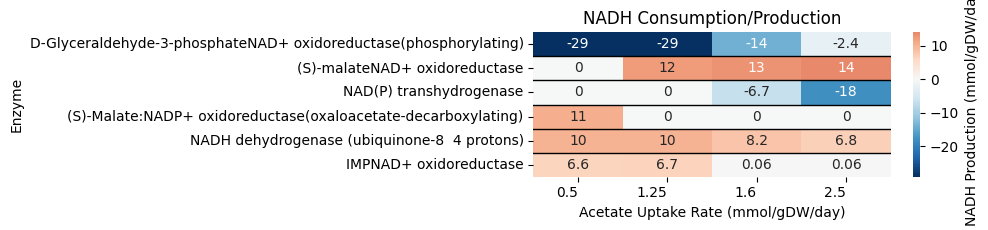

In [18]:
rid2name, rxnclasses = writeDicts(top_rxns_anadh)

# Combine NADH dataframe and add column for labeling
anadh_combined = pd.concat([
    anadh_all.assign(Cofactor='NADH'),
])
anadh_combined['Condition_Cofactor'] = anadh_combined['Condition']

# Pivot to wide format
anadh_heatmap_df = anadh_combined.pivot_table(index='Reaction', columns='Condition_Cofactor', values='Cofactor_flux').fillna(0)

# Build a sorted list of reactions by module
sorted_reactions = []
module_breaks = []
current_index = 0

# First, invert rxnclasses to get: module -> list of reactions
from collections import defaultdict

module_to_rxns = defaultdict(list)
for rxn, module in rxnclasses.items():
    module_to_rxns[module].append(rxn)

# Now build sorted list
sorted_reactions = []
module_breaks = []
current_index = 0

for module, rxn_list in module_to_rxns.items():
    present_rxns = [r for r in rxn_list if r in anadh_heatmap_df.index]
    if present_rxns:
        sorted_reactions.extend(present_rxns)
        current_index += len(present_rxns)
        module_breaks.append(current_index)

# Subset and reorder
anadh_heatmap_df_sorted = anadh_heatmap_df.loc[sorted_reactions]

# Replace reaction IDs with enzyme names
row_labels = [rid2name.get(rid, rid) for rid in anadh_heatmap_df_sorted.index]
anadh_heatmap_df_sorted.index = row_labels

# Plot heatmap with horizontal lines between modules
plt.figure(figsize=(10, len(row_labels) * 0.4))
ax = sns.heatmap(anadh_heatmap_df_sorted, cmap='RdBu_r', center=0, annot=True, cbar_kws={"label": "NADH Production (mmol/gDW/day)"})
# ax.collections[0].colorbar.ax.set_position([.2, .95, .6, .02])

# Add horizontal lines between modules
for i in module_breaks[:-1]:  # skip final boundary
    ax.axhline(i, color='black', linewidth=1)

# Rotate x-axis labels for readability
plt.xticks(rotation=0, ha='right')  # ← This line fixes overlapping labels
ax.set_title("NADH Consumption/Production")
ax.set_xlabel("Acetate Uptake Rate (mmol/gDW/day)")
ax.set_ylabel("Enzyme")
plt.tight_layout()

# Add module labels on the right side of the plot
y_tick_positions = []
start = 0

for module, rxn_list in rxnclasses.items():
    present_rxns = [r for r in rxn_list if r in anadh_heatmap_df.index]
    if not present_rxns:
        continue
    block_size = len(present_rxns)
    center = start + block_size / 2
    y_tick_positions.append(center)
    
    ax.text(
        x=len(anadh_heatmap_df_sorted.columns) - 0.95,  # right of the last column
        y=center,
        s=module,
        va='center',
        ha='left',
        fontsize=7,
        rotation=0,
        color='black',
        clip_on=False,
        transform=ax.get_yaxis_transform(which='grid')  # ensures correct vertical positioning
    )
    start += block_size

plt.show()

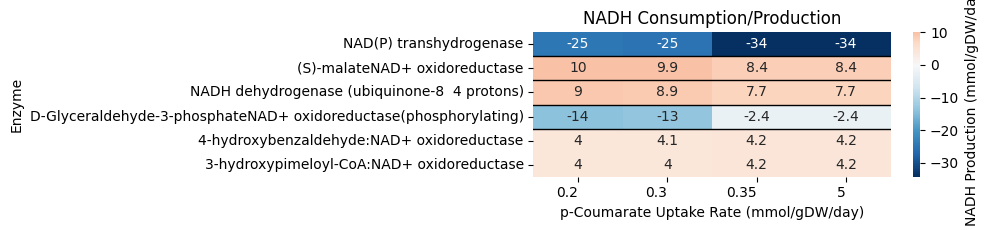

In [19]:
rid2name, rxnclasses = writeDicts(top_rxns_cnadh)

# Combine NADH dataframe and add column for labeling
cnadh_combined = pd.concat([
    cnadh_all.assign(Cofactor='NADH'),
])
cnadh_combined['Condition_Cofactor'] = cnadh_combined['Condition']

# Pivot to wide format
cnadh_heatmap_df = cnadh_combined.pivot_table(index='Reaction', columns='Condition_Cofactor', values='Cofactor_flux').fillna(0)

# Build a sorted list of reactions by module
sorted_reactions = []
module_breaks = []
current_index = 0

# First, invert rxnclasses to get: module -> list of reactions
from collections import defaultdict

module_to_rxns = defaultdict(list)
for rxn, module in rxnclasses.items():
    module_to_rxns[module].append(rxn)

# Now build sorted list
sorted_reactions = []
module_breaks = []
current_index = 0

for module, rxn_list in module_to_rxns.items():
    present_rxns = [r for r in rxn_list if r in cnadh_heatmap_df.index]
    if present_rxns:
        sorted_reactions.extend(present_rxns)
        current_index += len(present_rxns)
        module_breaks.append(current_index)

# Subset and reorder
cnadh_heatmap_df_sorted = cnadh_heatmap_df.loc[sorted_reactions]

# Replace reaction IDs with enzyme names
row_labels = [rid2name.get(rid, rid) for rid in cnadh_heatmap_df_sorted.index]
cnadh_heatmap_df_sorted.index = row_labels

# Plot heatmap with horizontal lines between modules
plt.figure(figsize=(10, len(row_labels) * 0.4))
ax = sns.heatmap(cnadh_heatmap_df_sorted, cmap='RdBu_r', center=0, annot=True, cbar_kws={"label": "NADH Production (mmol/gDW/day)"})
# ax.collections[0].colorbar.ax.set_position([.2, .95, .6, .02])

# Add horizontal lines between modules
for i in module_breaks[:-1]:  # skip final boundary
    ax.axhline(i, color='black', linewidth=1)

# Rotate x-axis labels for readability
plt.xticks(rotation=0, ha='right')  # ← This line fixes overlapping labels
ax.set_title("NADH Consumption/Production")
ax.set_xlabel("p-Coumarate Uptake Rate (mmol/gDW/day)")
ax.set_ylabel("Enzyme")
plt.tight_layout()

# Add module labels on the right side of the plot
y_tick_positions = []
start = 0

for module, rxn_list in rxnclasses.items():
    present_rxns = [r for r in rxn_list if r in cnadh_heatmap_df.index]
    if not present_rxns:
        continue
    block_size = len(present_rxns)
    center = start + block_size / 2
    y_tick_positions.append(center)
    
    ax.text(
        x=len(cnadh_heatmap_df_sorted.columns) - 0.95,  # right of the last column
        y=center,
        s=module,
        va='center',
        ha='left',
        fontsize=7,
        rotation=0,
        color='black',
        clip_on=False,
        transform=ax.get_yaxis_transform(which='grid')  # ensures correct vertical positioning
    )
    start += block_size

plt.show()

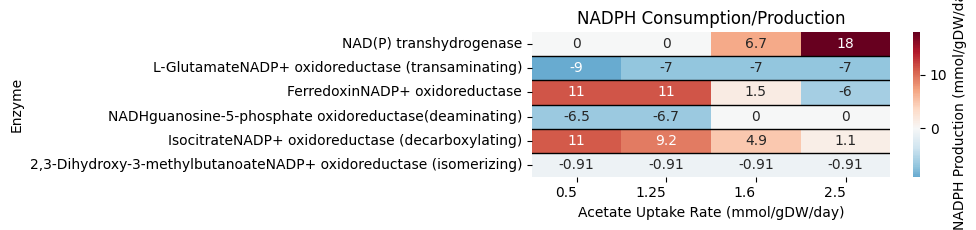

In [20]:
rid2name, rxnclasses = writeDicts(top_rxns_anadph)

# Combine NADPH dataframe and add column for labeling
anadph_combined = pd.concat([
    anadph_all.assign(Cofactor='NADPH'),
])
anadph_combined['Condition_Cofactor'] = anadph_combined['Condition']

# Pivot to wide format
anadph_heatmap_df = anadph_combined.pivot_table(index='Reaction', columns='Condition_Cofactor', values='Cofactor_flux').fillna(0)

# Build a sorted list of reactions by module
sorted_reactions = []
module_breaks = []
current_index = 0

# First, invert rxnclasses to get: module -> list of reactions
from collections import defaultdict

module_to_rxns = defaultdict(list)
for rxn, module in rxnclasses.items():
    module_to_rxns[module].append(rxn)

# Now build sorted list
sorted_reactions = []
module_breaks = []
current_index = 0

for module, rxn_list in module_to_rxns.items():
    present_rxns = [r for r in rxn_list if r in anadph_heatmap_df.index]
    if present_rxns:
        sorted_reactions.extend(present_rxns)
        current_index += len(present_rxns)
        module_breaks.append(current_index)

# Subset and reorder
anadph_heatmap_df_sorted = anadph_heatmap_df.loc[sorted_reactions]

# Replace reaction IDs with enzyme names
row_labels = [rid2name.get(rid, rid) for rid in anadph_heatmap_df_sorted.index]
anadph_heatmap_df_sorted.index = row_labels

# Plot heatmap with horizontal lines between modules
plt.figure(figsize=(10, len(row_labels) * 0.4))
ax = sns.heatmap(anadph_heatmap_df_sorted, cmap='RdBu_r', center=0, annot=True, cbar_kws={"label": "NADPH Production (mmol/gDW/day)"})
# ax.collections[0].colorbar.ax.set_position([.2, .95, .6, .02])

# Add horizontal lines between modules
for i in module_breaks[:-1]:  # skip final boundary
    ax.axhline(i, color='black', linewidth=1)

# Rotate x-axis labels for readability
plt.xticks(rotation=0, ha='right')  # ← This line fixes overlapping labels
ax.set_title("NADPH Consumption/Production")
ax.set_xlabel("Acetate Uptake Rate (mmol/gDW/day)")
ax.set_ylabel("Enzyme")
plt.tight_layout()

# Add module labels on the right side of the plot
y_tick_positions = []
start = 0

for module, rxn_list in rxnclasses.items():
    present_rxns = [r for r in rxn_list if r in anadph_heatmap_df.index]
    if not present_rxns:
        continue
    block_size = len(present_rxns)
    center = start + block_size / 2
    y_tick_positions.append(center)
    
    ax.text(
        x=len(anadph_heatmap_df_sorted.columns) - 0.95,  # right of the last column
        y=center,
        s=module,
        va='center',
        ha='left',
        fontsize=7,
        rotation=0,
        color='black',
        clip_on=False,
        transform=ax.get_yaxis_transform(which='grid')  # ensures correct vertical positioning
    )
    start += block_size

plt.show()

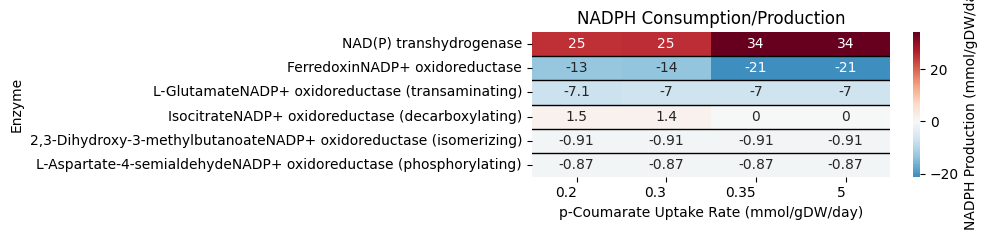

In [21]:
rid2name, rxnclasses = writeDicts(top_rxns_cnadph)

# Combine NADH dataframe and add column for labeling
cnadph_combined = pd.concat([
    cnadph_all.assign(Cofactor='NADPH'),
])
cnadph_combined['Condition_Cofactor'] = cnadph_combined['Condition']

# Pivot to wide format
cnadph_heatmap_df = cnadph_combined.pivot_table(index='Reaction', columns='Condition_Cofactor', values='Cofactor_flux').fillna(0)

# Build a sorted list of reactions by module
sorted_reactions = []
module_breaks = []
current_index = 0

# First, invert rxnclasses to get: module -> list of reactions
from collections import defaultdict

module_to_rxns = defaultdict(list)
for rxn, module in rxnclasses.items():
    module_to_rxns[module].append(rxn)

# Now build sorted list
sorted_reactions = []
module_breaks = []
current_index = 0

for module, rxn_list in module_to_rxns.items():
    present_rxns = [r for r in rxn_list if r in cnadph_heatmap_df.index]
    if present_rxns:
        sorted_reactions.extend(present_rxns)
        current_index += len(present_rxns)
        module_breaks.append(current_index)

# Subset and reorder
cnadph_heatmap_df_sorted = cnadph_heatmap_df.loc[sorted_reactions]

# Replace reaction IDs with enzyme names
row_labels = [rid2name.get(rid, rid) for rid in cnadph_heatmap_df_sorted.index]
cnadph_heatmap_df_sorted.index = row_labels

# Plot heatmap with horizontal lines between modules
plt.figure(figsize=(10, len(row_labels) * 0.4))
ax = sns.heatmap(cnadph_heatmap_df_sorted, cmap='RdBu_r', center=0, annot=True, cbar_kws={"label": "NADPH Production (mmol/gDW/day)"})
# ax.collections[0].colorbar.ax.set_position([.2, .95, .6, .02])

# Add horizontal lines between modules
for i in module_breaks[:-1]:  # skip final boundary
    ax.axhline(i, color='black', linewidth=1)

# Rotate x-axis labels for readability
plt.xticks(rotation=0, ha='right')  # ← This line fixes overlapping labels
ax.set_title("NADPH Consumption/Production")
ax.set_xlabel("p-Coumarate Uptake Rate (mmol/gDW/day)")
ax.set_ylabel("Enzyme")
plt.tight_layout()

# Add module labels on the right side of the plot
y_tick_positions = []
start = 0

for module, rxn_list in rxnclasses.items():
    present_rxns = [r for r in rxn_list if r in cnadph_heatmap_df.index]
    if not present_rxns:
        continue
    block_size = len(present_rxns)
    center = start + block_size / 2
    y_tick_positions.append(center)
    
    ax.text(
        x=len(cnadph_heatmap_df_sorted.columns) - 0.95,  # right of the last column
        y=center,
        s=module,
        va='center',
        ha='left',
        fontsize=7,
        rotation=0,
        color='black',
        clip_on=False,
        transform=ax.get_yaxis_transform(which='grid')  # ensures correct vertical positioning
    )
    start += block_size

plt.show()

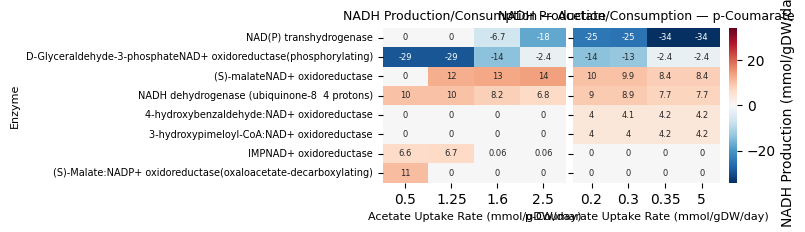

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# --- Align row indices across both dataframes ---
all_rows = sorted(set(map(str, anadh_heatmap_df_sorted.index)) | set(map(str, cnadh_heatmap_df_sorted.index)))
anadh_heatmap_df_sorted.index = anadh_heatmap_df_sorted.index.map(str)
cnadh_heatmap_df_sorted.index = cnadh_heatmap_df_sorted.index.map(str)

anadh_plot = anadh_heatmap_df_sorted.reindex(all_rows).fillna(0)
cnadh_plot = cnadh_heatmap_df_sorted.reindex(all_rows).fillna(0)

# --- Compute total activity per row (sum of absolute values across both datasets) ---
total_activity = (anadh_plot.abs().sum(axis=1) + cnadh_plot.abs().sum(axis=1))
sorted_rows = total_activity.sort_values(ascending=False).index  # largest → smallest

# Reindex both in this order
anadh_plot = anadh_plot.reindex(sorted_rows)
cnadh_plot = cnadh_plot.reindex(sorted_rows)

# --- Shared color scale ---
vmax = np.nanmax([anadh_plot.values, cnadh_plot.values])
vmin = np.nanmin([anadh_plot.values, cnadh_plot.values])
vmax = max(abs(vmax), abs(vmin))  # symmetric scale
vmin = -vmax

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(8, len(sorted_rows)*0.3), sharey=True)

# --- Left heatmap: Acetate ---
sns.heatmap(
    anadh_plot,
    cmap='RdBu_r',
    center=0,
    vmin=vmin, vmax=vmax,
    annot=True,
    annot_kws={"size": 6},
    cbar=False,
    ax=axes[0]
)
axes[0].set_title("NADH Production/Consumption — Acetate", fontsize=9)
axes[0].set_xlabel("Acetate Uptake Rate (mmol/gDW/day)", fontsize=8)
axes[0].set_ylabel("Enzyme", fontsize=8)

# --- Right heatmap: p-Coumarate ---
sns.heatmap(
    cnadh_plot,
    cmap='RdBu_r',
    center=0,
    vmin=vmin, vmax=vmax,
    annot=True,
    annot_kws={"size": 6},
    cbar_kws={"label": "NADH Production (mmol/gDW/day)"},
    ax=axes[1]
)
axes[1].set_title("NADH Production/Consumption — p-Coumarate", fontsize=9)
axes[1].set_xlabel("p-Coumarate Uptake Rate (mmol/gDW/day)", fontsize=8)
axes[1].set_ylabel("")

# --- Formatting ---
for ax in axes:
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', labelsize=7)

plt.tight_layout(pad=1.0, w_pad=0.5)
plt.savefig("Fig1B.svg", bbox_inches='tight')
plt.show()


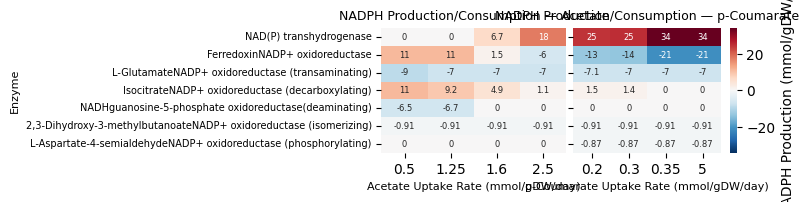

In [27]:
# --- Align row indices across both dataframes ---
all_rows = sorted(set(map(str, anadph_heatmap_df_sorted.index)) | set(map(str, cnadph_heatmap_df_sorted.index)))
anadph_heatmap_df_sorted.index = anadph_heatmap_df_sorted.index.map(str)
cnadph_heatmap_df_sorted.index = cnadph_heatmap_df_sorted.index.map(str)

anadph_plot = anadph_heatmap_df_sorted.reindex(all_rows).fillna(0)
cnadph_plot = cnadph_heatmap_df_sorted.reindex(all_rows).fillna(0)

# --- Compute total activity per row (sum of absolute values across both datasets) ---
total_activity = (anadph_plot.abs().sum(axis=1) + cnadph_plot.abs().sum(axis=1))
sorted_rows = total_activity.sort_values(ascending=False).index  # largest → smallest

# Reindex both in this order
anadph_plot = anadph_plot.reindex(sorted_rows)
cnadph_plot = cnadph_plot.reindex(sorted_rows)

# --- Shared color scale ---
vmax = np.nanmax([anadph_plot.values, cnadph_plot.values])
vmin = np.nanmin([anadph_plot.values, cnadph_plot.values])
vmax = max(abs(vmax), abs(vmin))  # symmetric scale
vmin = -vmax

# --- Create subplots ---
fig, axes = plt.subplots(1, 2, figsize=(8, len(sorted_rows)*0.3), sharey=True)

# --- Left heatmap: Acetate ---
sns.heatmap(
    anadph_plot,
    cmap='RdBu_r',
    center=0,
    vmin=vmin, vmax=vmax,
    annot=True,
    annot_kws={"size": 6},
    cbar=False,
    ax=axes[0]
)
axes[0].set_title("NADPH Production/Consumption — Acetate", fontsize=9)
axes[0].set_xlabel("Acetate Uptake Rate (mmol/gDW/day)", fontsize=8)
axes[0].set_ylabel("Enzyme", fontsize=8)

# --- Right heatmap: p-Coumarate ---
sns.heatmap(
    cnadph_plot,
    cmap='RdBu_r',
    center=0,
    vmin=vmin, vmax=vmax,
    annot=True,
    annot_kws={"size": 6},
    cbar_kws={"label": "NADPH Production (mmol/gDW/day)"},
    ax=axes[1]
)
axes[1].set_title("NADPH Production/Consumption — p-Coumarate", fontsize=9)
axes[1].set_xlabel("p-Coumarate Uptake Rate (mmol/gDW/day)", fontsize=8)
axes[1].set_ylabel("")

# --- Formatting ---
for ax in axes:
    ax.tick_params(axis='x', rotation=0)
    ax.tick_params(axis='y', labelsize=7)

plt.tight_layout(pad=1.0, w_pad=0.5)
plt.savefig("Fig1C.svg", bbox_inches='tight')
plt.show()

## Fig 1D

In [18]:
pathway_groups = {
    "TCA cycle": [
        "Citrate cycle (TCA cycle)",
        "Glyoxylate and dicarboxylate metabolism"
    ],

    "Fatty acid metabolism": [
        "Fatty acid biosynthesis",
        "Fatty acid metabolism",
        "Glycerophospholipid metabolism",
        "Propanoate metabolism"
    ],

    "Carbon fixation": [
        "Carbon fixation in photosynthetic organisms"
    ],

    "Amino acid metabolism": [
        "Glycine, serine and threonine metabolism",
        "Valine, leucine and isoleucine biosynthesis",
        "Arginine and proline metabolism",
        "Lysine biosynthesis",
        "Phenylalanine, tyrosine and tryptophan biosynthesis",
        "Histidine metabolism",
        "Glutamate metabolism",
        "Urea cycle and metabolism of amino groups",
        "Sulfur metabolism"
    ],

    "Nucleotide metabolism": [
        "Purine metabolism",
        "Pyrimidine metabolism",
        "One carbon pool by folate"
    ],

    "Cofactor and vitamin metabolism": [
        "Nicotinate and nicotinamide metabolism",
        "Pantothenate and CoA biosynthesis",
        "Vitamin B6 metabolism",
        "Riboflavin metabolism"
    ],

    "Energy metabolism": [
        "Oxidative phosphorylation",
        "Ubiquinone biosynthesis",
        "Terpenoid backbone biosynthesis",
        "Carotenoid biosynthesis"
    ],

    "Carbohydrate metabolism": [
        "Glycolysis / Gluconeogenesis",
        "Aminosugars metabolism"
    ],

    "Secondary metabolism / degradation": [
        "Benzoate degradation",
        "Porphyrin and chlorophyll metabolism"
    ],

    "Other": [
        "nan"
    ]
}

In [19]:
combined_a_df = pd.concat([a4_nadh_df, a4_nadph_df])
df_reset_combined_a_df = combined_a_df.reset_index()

paths = []

for i, row in combined_a_df.iterrows():
    rxn = row['Reaction']
    match = mdetails[mdetails['Rxn name'] == rxn]
    pathway = match['Pathway'].values[0]
    broad_key = [key for key, val in pathway_groups.items() if pathway in val]
    
    if broad_key:
        paths.append(broad_key[0])
    else:
        paths.append('Biomass')

combined_a_df['Pathway'] = paths

In [20]:
combined_c_df = pd.concat([c4_nadh_df, c4_nadph_df])
df_reset_combined_c_df = combined_c_df.reset_index()

paths = []

for i, row in combined_c_df.iterrows():
    rxn = row['Reaction']
    match = mdetails[mdetails['Rxn name'] == rxn]
    pathway = match['Pathway'].values[0]
    broad_key = [key for key, val in pathway_groups.items() if pathway in val]
    
    if broad_key:
        paths.append(broad_key[0])
    else:
        paths.append('Biomass')

combined_c_df['Pathway'] = paths

In [21]:
# Example: combine both DataFrames with a label for each condition
combined_a_df['Condition'] = 'Acetate'
combined_c_df['Condition'] = 'p-Coumarate'
combined = pd.concat([combined_a_df, combined_c_df], ignore_index=True)

# Split into positive and negative contributions *before* summing
combined['Flux_type'] = combined['Cofactor_flux'].apply(lambda x: 'Production' if x > 0 else 'Consumption')

# Sum absolute flux per pathway, per condition, per direction
agg = (
    combined.groupby(['Condition', 'Pathway', 'Flux_type'])['Cofactor_flux']
    .sum()
    .unstack(fill_value=0)  # columns: Consumption, Production
)

# Make sure all missing directions exist
if 'Consumption' not in agg.columns:
    agg['Consumption'] = 0
if 'Production' not in agg.columns:
    agg['Production'] = 0

# Sort pathways by total absolute flux
agg = agg.loc[agg.abs().sum(axis=1).sort_values(ascending=False).index]

# Separate data for plotting
conditions = combined['Condition'].unique()
pathways = agg.index

# Build per-condition tables
plot_data = (
    combined.groupby(['Condition', 'Pathway'])['Cofactor_flux']
    .apply(list)
    .groupby(level=0)
    .apply(lambda x: x.apply(sum))
)

# Prepare a tidy table for stacking
plot_table = (
    combined.groupby(['Condition', 'Pathway'])['Cofactor_flux']
    .sum()
    .unstack(fill_value=0)
)

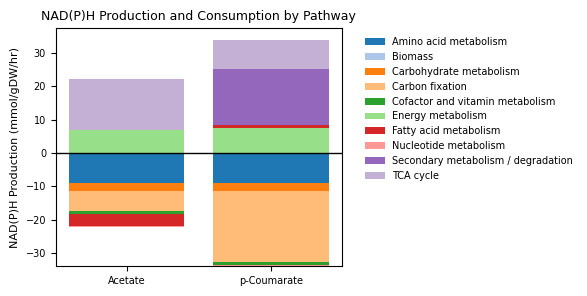

In [22]:
plt.rcParams.update({
    'font.size': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 9,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7
})

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(6, 3))

bottom_pos = pd.Series(0, index=plot_table.index)
bottom_neg = pd.Series(0, index=plot_table.index)

colors = plt.cm.tab20.colors  # or any palette
color_map = {pathway: colors[i % len(colors)] for i, pathway in enumerate(plot_table.columns)}

for pathway in plot_table.columns:
    vals = plot_table[pathway]
    pos = vals.clip(lower=0)
    neg = vals.clip(upper=0)
    
    ax.bar(plot_table.index, pos, bottom=bottom_pos, color=color_map[pathway], label=pathway)
    ax.bar(plot_table.index, neg, bottom=bottom_neg, color=color_map[pathway], label="_nolegend_")

    bottom_pos += pos
    bottom_neg += neg


# --- Formatting ---
ax.axhline(0, color='black', linewidth=1)
ax.set_ylabel("NAD(P)H Production (mmol/gDW/hr)")
ax.set_xlabel("")
ax.set_title("NAD(P)H Production and Consumption by Pathway")
ax.tick_params(axis='x', labelrotation=0)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7, frameon=False)

plt.tight_layout()
# plt.savefig("Fig1D.svg", bbox_inches='tight')
plt.show()

In [24]:
plot_table.to_clipboard()